<a href="https://colab.research.google.com/github/deductiveclouds/Tensorflow/blob/main/%5BGK%5D_05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Preliminary setup for new runtime
!pip uninstall -y tensorflow
!pip install tensorflow=='2.15.0'
!pip freeze | grep tensorflow
!sudo apt install nvidia-utils-560

Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Successfully uninstalled tensorflow-2.17.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.0
    Uninstalling wrapt-1.17.0:
      Successfully uninstalled wrapt-1.17.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstallin

In [2]:
!nvidia-smi

Fri Dec 27 05:42:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0              48W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
# Get helper_functions.py from github
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import functions to use from above file
from helper_functions import (
    create_tensorboard_callback,
    plot_loss_curves,
    unzip_data,
    walk_through_dir,
)

--2024-12-27 05:42:34--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-12-27 05:42:34 (114 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [4]:
# # Get 10% of the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# # Unzip the data
unzip_data("10_food_classes_10_percent.zip")

--2024-12-27 05:42:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.207, 173.194.194.207, 142.250.152.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   206MB/s    in 0.8s    

2024-12-27 05:42:39 (206 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [5]:
# Walk through the directory for 10 percent
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [6]:
# Create path names to directories for 10 percent
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test"

In [7]:
# Create input data for 10 percent
import tensorflow as tf

IMAGE_SIZE = (224, 224, 3)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=IMAGE_SIZE[:2],
    label_mode="categorical",
    batch_size=BATCH_SIZE,
)
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir, image_size=IMAGE_SIZE[:2], label_mode="categorical"
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
# Check out the data
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
# Check out the labels
test_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# See contents of a batch of data
import random

batch_num = random.randint(0, len(train_data_10_percent))
for index, items in enumerate(train_data_10_percent.take(batch_num)):
    print(index, items[0].shape, items[1].shape)

0 (32, 224, 224, 3) (32, 10)
1 (32, 224, 224, 3) (32, 10)
2 (32, 224, 224, 3) (32, 10)
3 (32, 224, 224, 3) (32, 10)
4 (32, 224, 224, 3) (32, 10)
5 (32, 224, 224, 3) (32, 10)
6 (32, 224, 224, 3) (32, 10)
7 (32, 224, 224, 3) (32, 10)
8 (32, 224, 224, 3) (32, 10)
9 (32, 224, 224, 3) (32, 10)
10 (32, 224, 224, 3) (32, 10)
11 (32, 224, 224, 3) (32, 10)
12 (32, 224, 224, 3) (32, 10)


In [11]:
# Create and fit the baseline model_0
from os import name

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=IMAGE_SIZE, name="input_layer")
x = base_model(inputs)

x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer_2d")(x)

outputs = tf.keras.layers.Dense(units=10, activation="softmax", name="output_layer")(x)

model_0 = tf.keras.Model(inputs, outputs)

model_0.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"],
)

history_model_0 = model_0.fit(
    x=train_data_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data_10_percent,
    validation_steps=len(test_data_10_percent),
    callbacks=[
        create_tensorboard_callback(
            dir_name="transfer_learning", experiment_name="model_0"
        )
    ],
)

Saving TensorBoard log files to: transfer_learning/model_0/20241227-054246
Epoch 1/5
24/24 [==============================] - 14s 167ms/step - loss: 1.9482 - accuracy: 0.3693 - val_loss: 1.3633 - val_accuracy: 0.7176
Epoch 2/5
24/24 [==============================] - 2s 83ms/step - loss: 1.1743 - accuracy: 0.7320 - val_loss: 0.9188 - val_accuracy: 0.8084
Epoch 3/5
24/24 [==============================] - 2s 81ms/step - loss: 0.8490 - accuracy: 0.8187 - val_loss: 0.7268 - val_accuracy: 0.8404
Epoch 4/5
24/24 [==============================] - 2s 81ms/step - loss: 0.7010 - accuracy: 0.8373 - val_loss: 0.6336 - val_accuracy: 0.8492
Epoch 5/5
24/24 [==============================] - 2s 81ms/step - loss: 0.5955 - accuracy: 0.8653 - val_loss: 0.5750 - val_accuracy: 0.8532


In [12]:
# Check based model layers
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [13]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [14]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er_2d (GlobalAveragePoolin                                      
 g2D)                                                            
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

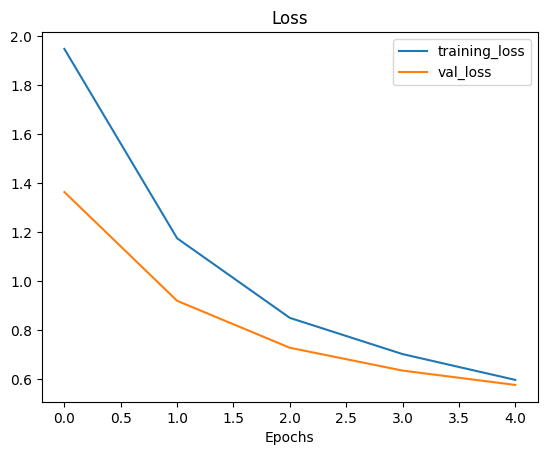

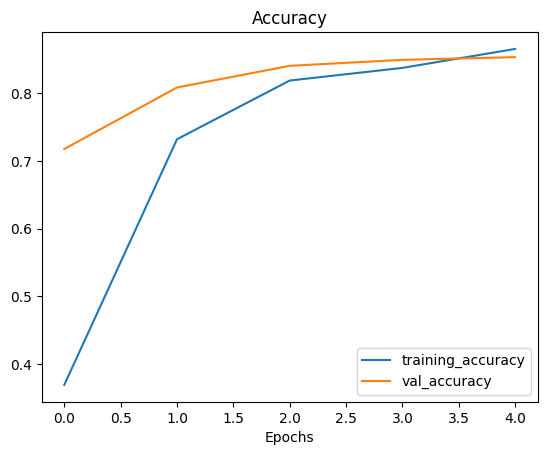

In [15]:
plot_loss_curves(history_model_0)

In [16]:
# Create 1 percent of the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2024-12-27 05:43:09--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.145.207, 142.250.125.207, 209.85.200.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.145.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   161MB/s    in 0.8s    

2024-12-27 05:43:10 (161 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [17]:
# Create path names to directories for 1 percent
train_dir = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

In [18]:
# Walk through the directory for 10 percent
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There a

In [19]:
# Create input data for 10 percent
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=IMAGE_SIZE[:2],
    label_mode="categorical",
    batch_size=BATCH_SIZE,
)
test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir, image_size=IMAGE_SIZE[:2], label_mode="categorical"
)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [20]:
# Create data augmentation layer
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip(mode="horizontal"),
        tf.keras.layers.RandomRotation(factor=0.2),
        tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
        tf.keras.layers.RandomHeight(factor=0.2),
        tf.keras.layers.RandomWidth(factor=0.2),
    ],
    name="data_augmentation",
)

In [21]:
# Create and fit the 1 percent with data augmentation model_1
inputs = tf.keras.layers.Input(shape=IMAGE_SIZE, name="input_layer")

x = data_augmentation(inputs)

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

x = base_model(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

outputs = tf.keras.layers.Dense(units=10, activation="softmax", name="output_layer")(x)

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"],
)

history_model_1 = model_1.fit(
    x=train_data_1_percent,
    epochs=5,
    steps_per_epoch=len(train_data_1_percent),
    validation_data=test_data_1_percent,
    validation_steps=(0.25 * len(test_data_1_percent)),
    callbacks=[
        create_tensorboard_callback(
            dir_name="transfer_learning", experiment_name="model_1"
        )
    ],
)

Saving TensorBoard log files to: transfer_learning/model_1/20241227-054315
Epoch 1/5
3/3 [==============================] - 10s 1s/step - loss: 2.3423 - accuracy: 0.1000 - val_loss: 2.1783 - val_accuracy: 0.1906
Epoch 2/5
3/3 [==============================] - 1s 509ms/step - loss: 2.1022 - accuracy: 0.2571 - val_loss: 2.0550 - val_accuracy: 0.2797
Epoch 3/5
3/3 [==============================] - 1s 477ms/step - loss: 1.9451 - accuracy: 0.4000 - val_loss: 1.9513 - val_accuracy: 0.3750
Epoch 4/5
3/3 [==============================] - 1s 464ms/step - loss: 1.8219 - accuracy: 0.4571 - val_loss: 1.8713 - val_accuracy: 0.4391
Epoch 5/5
3/3 [==============================] - 1s 468ms/step - loss: 1.6768 - accuracy: 0.6429 - val_loss: 1.7935 - val_accuracy: 0.4953


In [22]:
# Evaluate on the test data
results_1_percent_data_aug = model_1.evaluate(test_data_1_percent)
results_1_percent_data_aug

79/79 [==============================] - 2s 18ms/step - loss: 1.7827 - accuracy: 0.5000


[1.7827427387237549, 0.5]

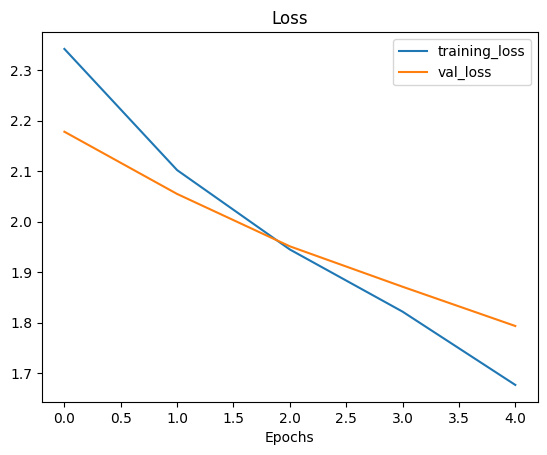

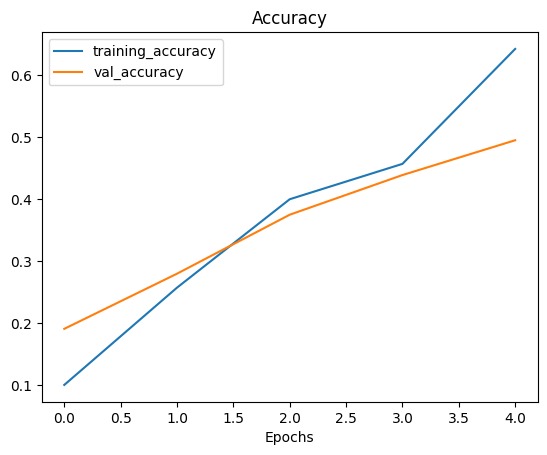

In [23]:
plot_loss_curves(history_model_1)

In [24]:
# Remove comment when starting a new runtime
import tensorflow as tf


def create_base_model(
    input_shape: tuple[int, int, int] = (224, 224, 3),
    output_shape: int = 10,
    learning_rate: float = 0.001,
    training: bool = False,
) -> tf.keras.Model:
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
        include_top=False
    )
    base_model.trainable = training
    inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = tf.keras.layers.Dense(
        units=output_shape, activation="softmax", name="output_layer"
    )(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=["accuracy"],
    )
    return model

In [25]:
model_2 = create_base_model()
checkpoint_path = "ten_percent_model_checkpoint_weights/checkpoint.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    save_freq="epoch",
    verbose=1,
)
initial_epochs = 5
history_model_2 = model_2.fit(
    x=train_data_10_percent,
    epochs=initial_epochs,
    validation_data=test_data_10_percent,
    validation_steps=int(0.25 * len(test_data_10_percent)),
    callbacks=[
        create_tensorboard_callback("transfer_learning", "10_percent_data_aug"),
        checkpoint_callback,
    ],
)

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20241227-054336
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9744 - accuracy: 0.3880
Epoch 1: val_loss improved from inf to 1.44503, saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 17s 414ms/step - loss: 1.9744 - accuracy: 0.3880 - val_loss: 1.4450 - val_accuracy: 0.6562
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3927 - accuracy: 0.6400
Epoch 2: val_loss improved from 1.44503 to 1.07456, saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 8s 342ms/step - loss: 1.3927 - accuracy: 0.6400 - val_loss: 1.0746 - val_accuracy: 0.7220
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.1164 - accuracy: 0.7293
Epoch 3: val_loss improved from 1.07456 to 0.82408, saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [=====

In [26]:
results_10_percent_data_aug = model_2.evaluate(test_data_10_percent)
results_10_percent_data_aug

79/79 [==============================] - 2s 18ms/step - loss: 0.6595 - accuracy: 0.8292


[0.6595144271850586, 0.829200029373169]

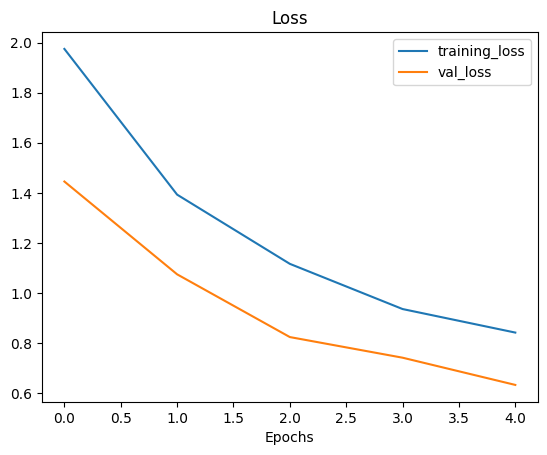

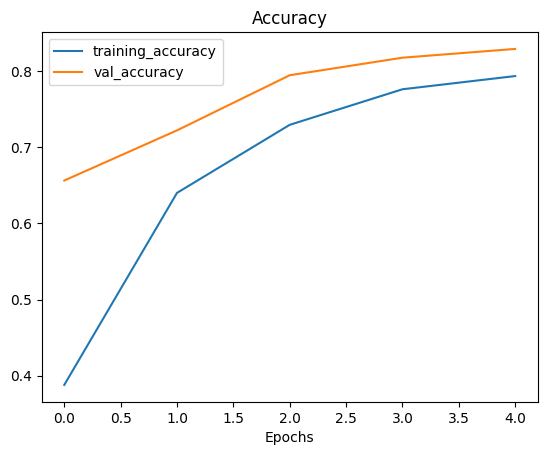

In [27]:
plot_loss_curves(history_model_2)

In [28]:
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data_10_percent)
results_10_percent_data_aug == loaded_weights_model_results

79/79 [==============================] - 2s 18ms/step - loss: 0.6595 - accuracy: 0.8292


True

In [29]:
# Remove comment when starting a new runtime
import numpy as np

np.isclose(results_10_percent_data_aug, loaded_weights_model_results)

array([ True,  True])

In [30]:
for layer_number, layer in enumerate(model_2.layers):
    print(
        f"Layer: {layer_number}, Layer name: {layer.name}, Trainable: {layer.trainable}"
    )

Layer: 0, Layer name: input_layer, Trainable: True
Layer: 1, Layer name: data_augmentation, Trainable: True
Layer: 2, Layer name: efficientnetv2-b0, Trainable: False
Layer: 3, Layer name: global_average_pooling_layer, Trainable: True
Layer: 4, Layer name: output_layer, Trainable: True


In [31]:
model_3 = model_2
model_3_base_model = model_3.layers[2]
model_3_base_model.name
model_3_base_model.trainable = True
for layer in model_3_base_model.layers[:-10]:
    layer.trainable = False
model_3.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"],
)
fine_tune_epochs = initial_epochs + 5
history_model_3 = model_3.fit(
    x=train_data_10_percent,
    epochs=fine_tune_epochs,
    steps_per_epoch=len(train_data_10_percent),
    initial_epoch=history_model_2.epoch[-1],
    validation_data=test_data_10_percent,
    validation_steps=int(0.25 * len(test_data_10_percent)),
    callbacks=[
        create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")
    ],
)

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20241227-054429
Epoch 5/10
24/24 [==============================] - 27s 727ms/step - loss: 0.6872 - accuracy: 0.8160 - val_loss: 0.5276 - val_accuracy: 0.8224
Epoch 6/10
24/24 [==============================] - 12s 514ms/step - loss: 0.6027 - accuracy: 0.8213 - val_loss: 0.4748 - val_accuracy: 0.8289
Epoch 7/10
24/24 [==============================] - 11s 456ms/step - loss: 0.5553 - accuracy: 0.8427 - val_loss: 0.4488 - val_accuracy: 0.8454
Epoch 8/10
24/24 [==============================] - 9s 356ms/step - loss: 0.5049 - accuracy: 0.8427 - val_loss: 0.4519 - val_accuracy: 0.8438
Epoch 9/10
24/24 [==============================] - 10s 413ms/step - loss: 0.4767 - accuracy: 0.8560 - val_loss: 0.4247 - val_accuracy: 0.8569
Epoch 10/10
24/24 [==============================] - 9s 367ms/step - loss: 0.4307 - accuracy: 0.8613 - val_loss: 0.4360 - val_accuracy: 0.8454


In [32]:
# Remove comment when starting a new runtime
import matplotlib.pyplot as plt


def compare_histories(original_history, new_history, initial_epochs=5):
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]
    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]
    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label="Training Accuracy")
    plt.plot(total_val_acc, label="Validation Accuracy")
    plt.plot(
        [initial_epochs - 1, initial_epochs - 1], plt.ylim(), label="Start Fine Tuning"
    )
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")
    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label="Training Loss")
    plt.plot(total_val_loss, label="Validation Loss")
    plt.plot(
        [initial_epochs - 1, initial_epochs - 1], plt.ylim(), label="Start Fine Tuning"
    )
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.show()

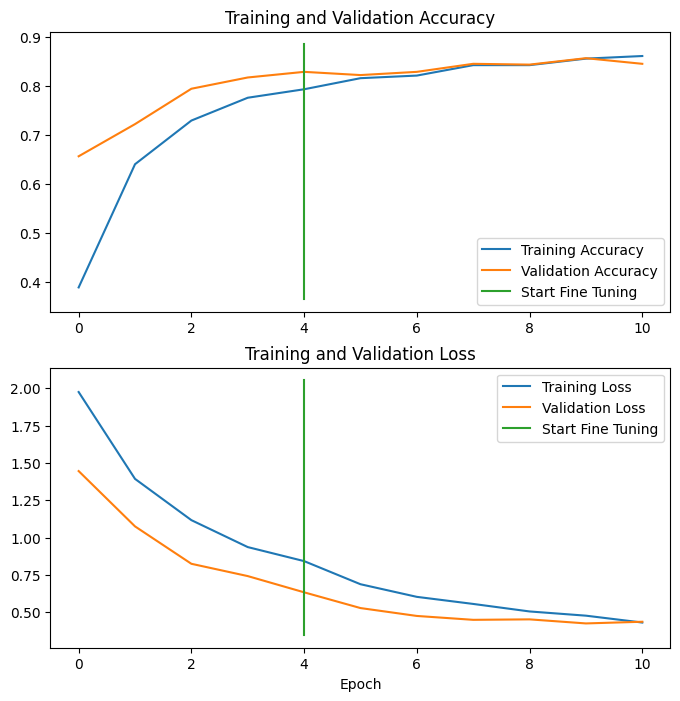

In [33]:
compare_histories(original_history=history_model_2, new_history=history_model_3)

In [37]:
# Remove comment when starting a new runtime
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data("10_food_classes_all_data.zip")

train_dir_full = "10_food_classes_all_data/train/"
test_dir_full = "10_food_classes_all_data/test/"

--2024-12-27 05:48:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.126.207, 74.125.132.207, 142.251.183.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.126.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   231MB/s    in 2.1s    

2024-12-27 05:48:35 (231 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [38]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.

In [39]:
train_data_full = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir_full,
    image_size=IMAGE_SIZE[:2],
    label_mode="categorical",
    batch_size=BATCH_SIZE,
)
test_data_full = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir_full,
    image_size=IMAGE_SIZE[:2],
    label_mode="categorical",
    batch_size=BATCH_SIZE,
)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [40]:
model_4 = create_base_model(learning_rate=0.0001)
model_4.load_weights(checkpoint_path)
model_4.evaluate(test_data_full)

79/79 [==============================] - 4s 19ms/step - loss: 0.6595 - accuracy: 0.8292


[0.6595144271850586, 0.829200029373169]

In [41]:
model_4_base_model = model_4.layers[2]
model_4_base_model.trainable = True
for layer in model_4_base_model.layers[:-10]:
    layer.trainable = False
model_4.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"],
)
fine_tune_epochs = initial_epochs + 5
history_model_4 = model_4.fit(
    x=train_data_full,
    epochs=fine_tune_epochs,
    steps_per_epoch=len(train_data_full),
    initial_epoch=history_model_2.epoch[-1],
    validation_data=test_data_full,
    validation_steps=int(0.25 * len(test_data_full)),
    callbacks=[
        create_tensorboard_callback(
            "transfer_learning", "full_10_classes_fine_tune_last_10"
        )
    ],
)

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20241227-054848
Epoch 5/10
235/235 [==============================] - 70s 264ms/step - loss: 0.7169 - accuracy: 0.7701 - val_loss: 0.3539 - val_accuracy: 0.8882
Epoch 6/10
235/235 [==============================] - 43s 184ms/step - loss: 0.5934 - accuracy: 0.8047 - val_loss: 0.3389 - val_accuracy: 0.8816
Epoch 7/10
235/235 [==============================] - 36s 152ms/step - loss: 0.5474 - accuracy: 0.8241 - val_loss: 0.3038 - val_accuracy: 0.8964
Epoch 8/10
235/235 [==============================] - 34s 143ms/step - loss: 0.5047 - accuracy: 0.8389 - val_loss: 0.2651 - val_accuracy: 0.9112
Epoch 9/10
235/235 [==============================] - 28s 121ms/step - loss: 0.4743 - accuracy: 0.8484 - val_loss: 0.2559 - val_accuracy: 0.9095
Epoch 10/10
235/235 [==============================] - 27s 115ms/step - loss: 0.4480 - accuracy: 0.8551 - val_loss: 0.2815 - val_accuracy: 0.8947


In [42]:
results_fine_tune_full_data = model_4.evaluate(test_data_full)
results_fine_tune_full_data

79/79 [==============================] - 2s 18ms/step - loss: 0.2641 - accuracy: 0.9100


[0.26408851146698, 0.9100000262260437]

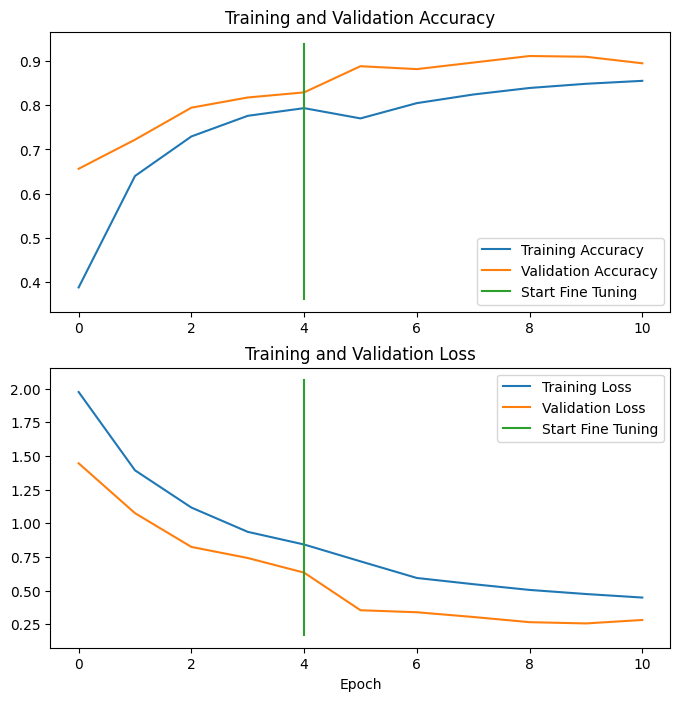

In [43]:
compare_histories(history_model_2, history_model_4)